# **1. Basics**
Importing required modules and Defining some useful functions.

In [1]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For utilities
import time, sys, os
sys.path.insert(0, '../../')

# For conversion
import cv2
import opencv_transforms.transforms as TF
import dataloader

# For everything
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.autograd import Variable

# For our model
import mymodels
import torchvision.models

# To ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    print("The gpu to be used : {}".format(torch.cuda.get_device_name(0)))
else:
    print("No gpu detected")

The gpu to be used : GeForce GTX 1060 6GB


# **1. Loading dataset**

## 1.1 Color to sketch converter

The `netC2S` is a network that convert a colorful image to sketch image. The network was pretrained on the dataset [1]. Even though there are some other methods to convert image to sketch like edge detection, Just forwarding another pretrained network is faster and gives better result.

[1] Taebum Kim, "Anime Sketch Colorization Pair", https://www.kaggle.com/ktaebum/anime-sketch-colorization-pair, 2019., 2020.1.13.

In [2]:
with torch.no_grad():
    netC2S = mymodels.Color2Sketch(pretrained=True).to(device)
    netC2S.eval()

Loading pretrained Color2Sketch model... Done!


## 1.2 Custom Dataloader

To pre-process input images, the module `opencv_transforms.transforms` and `opencv_transforms.functional` are used. These are implemented with **openCV** so much faster than `torchvision.transforms` which is based on **Pillow**.[2]

[2] Jim Bohnslav,"opencv_transforms",https://github.com/jbohnslav/opencv_transforms,2020.1.13.

In [3]:
# batch_size
batch_size = 2
ncluster = 9

# Training
print('Loading Training data...', end=' ')
train_transforms = TF.Compose([
    TF.RandomResizedCrop(256),
    TF.RandomHorizontalFlip(),
    ])
train_imagefolder = dataloader.PairImageFolder('../../dataset/anime/sketch/train', train_transforms, netC2S, ncluster)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=batch_size, shuffle=True)
print("Done!")
print("Training data size : {}".format(len(train_imagefolder)))
train_batch = next(iter(train_loader))

Loading Training data... Done!
Training data size : 14224


## 1.3 Dataset Test

Check the dataset.

In [4]:
temp_batch_iter = iter(train_loader)

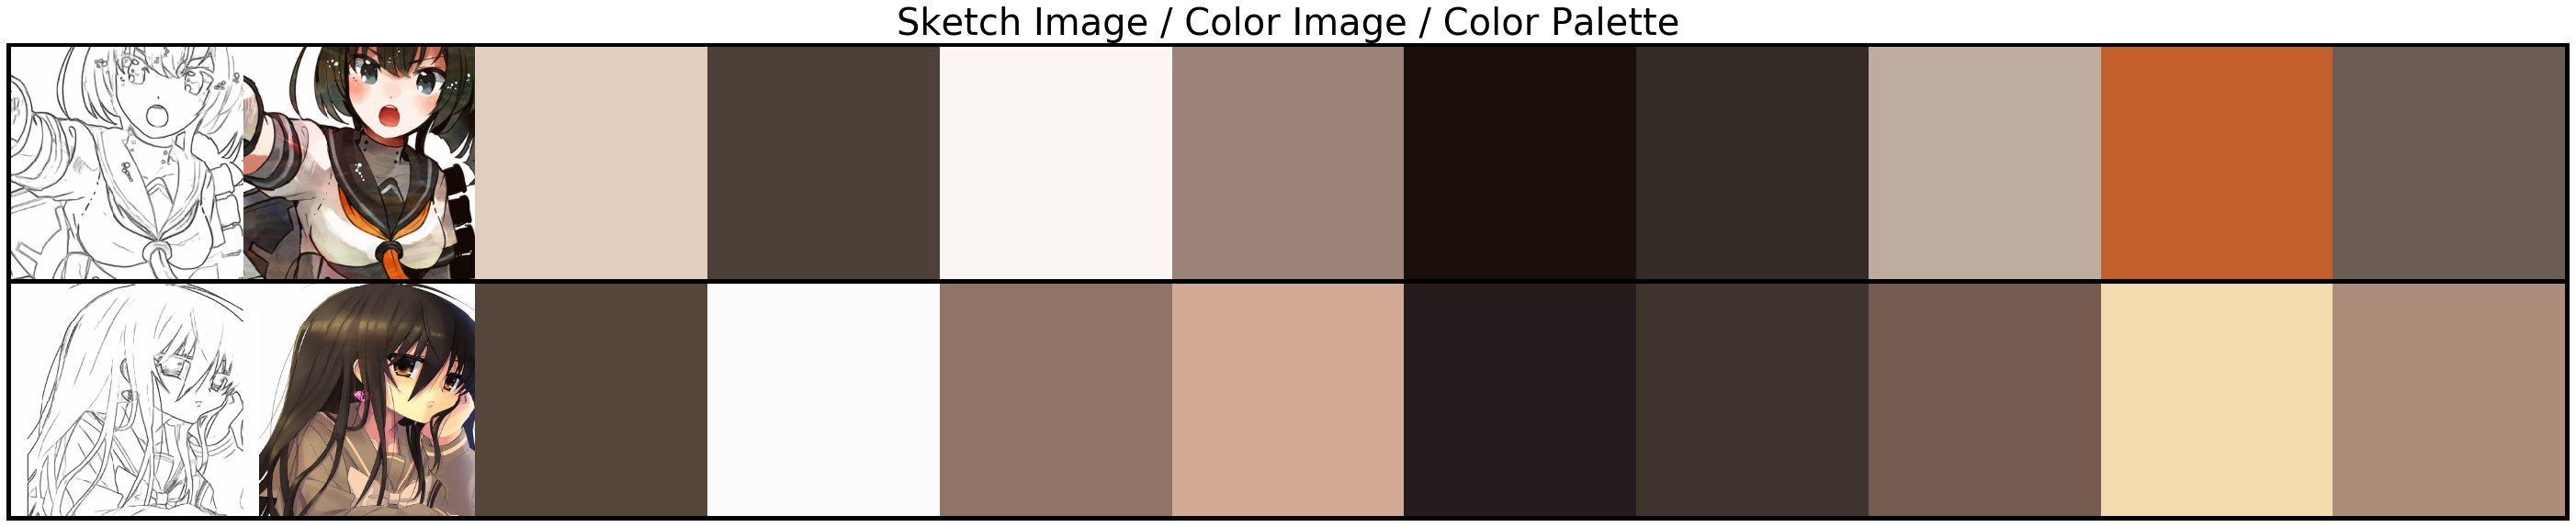

In [5]:
temp_batch = next(temp_batch_iter)
edge = temp_batch[0]
color = temp_batch[1]
color_list = temp_batch[2]

plt.figure(figsize=(50, 50))
result =torch.cat([edge, color] + color_list,dim=-1)
plt.imshow(np.transpose(vutils.make_grid(result, nrow=1, padding=5, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Sketch Image / Color Image / Color Palette", fontsize=40)
plt.show()

# **2. Construct the Model**

All models except `netEx` are implemented on `mymodels.py`. `netEx` is top four layers of VGG16 pretrained on ImageNet. This network extracts high level feature from input image. Meanwhile, referring to [3], the spectral normalization is applied to weights of discriminator.

[3] Takeru Miyato et al., "Spectral Normalization for Generative Adversarial Networks", ICLR 2018, 2018.2.18.

In [6]:
# A : Edge, B : Color
nc = 3 * (ncluster + 1)
netG = mymodels.Sketch2Color(nc=nc).to(device) 
netD = mymodels.Discriminator(nc=nc+3).to(device)
netEx = torchvision.models.vgg16(True).features[0:4].to(device)

num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad) + sum(p.numel() for p in netD.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

torch.backends.cudnn.benchmark = True

Weights of Sketch2Color model are initialized
Weights of Discriminator model are initialized
Number of parameters: 66301674


# **3. Train the Model**

## 3.1 Set hyperparameters, optimizer, loss, etc.

There are four loss fucntions which are

(1) Adversarial Loss (LSGAN)

(2) L1 distance between fake and real

(3) L2 distance between high level features of fake and real (extracted from four top layers of VGG16 pretrained on ImageNet)

(4) Total variance of fake image. (implemented based on [3])

[3]  jxgu1016,"Total_Variation_Loss.pytorch",https://github.com/jxgu1016/Total_Variation_Loss.pytorch

In [7]:
class TVLoss(nn.Module):
    def __init__(self,TVLoss_weight=1.0):
        super(TVLoss,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self._tensor_size(x[:,:,1:,:])
        count_w = self._tensor_size(x[:,:,:,1:])
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size

    def _tensor_size(self,t):
        return t.size()[1]*t.size()[2]*t.size()[3]

In [8]:
# epoch_num
current_epoch=0
epoch_num = 25
# learning rate
lr = 2e-4
# Loss functions
criterion_GAN = torch.nn.MSELoss() # LSGAN
criterion_L1 = torch.nn.L1Loss() # L1 Loss
criterion_L2 = torch.nn.MSELoss() # L2 Loss
criterion_TV = TVLoss() # Total variance Loss
# Lambda
lambda1 = 100
lambda2 = 1e-4
lambda3 = 1e-2
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.999
# Setup Adam optimizers for both G and D
optimizer_G = torch.optim.Adam(netG.parameters(),lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta2, beta2))

## 3.2 Train the model


In [9]:
# Lists to keep track of progress
loss_list_D = []
loss_list_G = []

In [10]:
# Training Loop
netG.train()
netD.train()

print("Starting Training Loop...")
# For each epoch
start_epoch = current_epoch
last_epoch = epoch_num + current_epoch - 1
for epoch in range(current_epoch, epoch_num + current_epoch):
    current_epoch += 1
       
    start_time = time.time()
    total_time = 0
    
    print('Epoch [{0}/{1}]'.format(epoch, last_epoch))
    for i, data in enumerate(train_loader, 0):                  
            
        # Set model input
        edge = data[0].to(device)
        color = data[1].to(device)
        color_list = data[2]
        input_tensor = torch.cat([edge.cpu()] + color_list, dim=1).to(device)
        b_size = edge.size(0)
        
        # Real & Fake Lebel
        real_label = Variable(torch.cuda.FloatTensor(b_size).fill_(0.9), requires_grad=False)
        fake_label = Variable(torch.cuda.FloatTensor(b_size).fill_(0.0), requires_grad=False)
                             
        ###### Outputs ######
        fake = netG(input_tensor)
        pred_fake = netD(input_tensor, fake)
        pred_real = netD(input_tensor, color)
        ##################################

        ###### Discriminator ######
        optimizer_D.zero_grad()
        
        # GAN loss
        loss_D_GAN = criterion_GAN(pred_fake, fake_label) + criterion_GAN(pred_real, real_label)

        # Total loss
        loss_D = 1.0 * loss_D_GAN
        loss_D.backward()

        # Update
        optimizer_D.step()
        ###################################

        ###### Outputs ######
        fake = netG(input_tensor)
        pred_fake = netD(input_tensor, fake)
        pred_real = netD(input_tensor, color)
        fake_feature = netEx(fake)
        real_feature = netEx(color)
        ##################################
        
        ###### Generators ######
        optimizer_G.zero_grad()
        
        # GAN loss
        loss_G_GAN = criterion_GAN(pred_fake, real_label)
        
        # L1 Loss
        loss_L1 = criterion_L1(fake, color)
        
        # Variance Loss
        loss_TV = criterion_TV(fake)
        
        # Feature Loss
        loss_Feature = criterion_L2(fake_feature, real_feature)
        
        # Total loss
        loss_G = 1.0 * loss_G_GAN + lambda1 * loss_L1 + lambda2 * loss_TV + lambda3 * loss_Feature
        loss_G.backward()
        
        # Update
        optimizer_G.step()
        ###################################

        if i%5 == 0:
            # Time Info.
            end_time = time.time()
            taken_time = end_time - start_time
            total_time += taken_time
            average_time = total_time / (i+1)

            # Output training stats
            print('\r[%d/%d] Loss D: %.2f / Loss_G: %.2f / Loss_G_GAN: %.2f / Loss_L1: %.2f /'\
                  ' Loss_TV: %.2f / Loss_Feature: %.2f / Time : %.2f (%.2f)'
                  % (i+1, len(train_loader), loss_D.item(), loss_G.item(), loss_G_GAN.item(), 
                     loss_L1.item(), loss_TV, loss_Feature, taken_time, average_time), end='     ')
            start_time = end_time
            
        if i%1000 == 0:
            print()
            #save(netG, netD, current_epoch)
            
        
        # Record loss
        loss_list_D.append(loss_D.cpu().item())
        loss_list_G.append(loss_G.cpu().item())
    print()
    
print('Done')

Starting Training Loop...
Epoch [0/24]
[1/7112] Loss D: 0.38 / Loss_G: 100.69 / Loss_G_GAN: 0.78 / Loss_L1: 1.00 / Loss_TV: 2.89 / Loss_Feature: 6.01 / Time : 13.83 (13.83)     
[16/7112] Loss D: 0.56 / Loss_G: 46.70 / Loss_G_GAN: 0.19 / Loss_L1: 0.46 / Loss_TV: 0.61 / Loss_Feature: 1.53 / Time : 4.77 (1.74)     

KeyboardInterrupt: 

# **4. Save / Load the model**

## 4.1 Save the model

In [11]:
def save(netG, netD, epoch):
    global loss_list_D, loss_list_G, optimizer_G, optimizer_D
    print('Saving...', end=' ')
    state = {
        'epoch': current_epoch,
        'netG': netG.state_dict(),
        'netD': netD.state_dict(),
        'loss_list_D' : loss_list_D,
        'loss_list_G' : loss_list_G,
        'optimizer_G': optimizer_G.state_dict(),
        'optimizer_D': optimizer_D.state_dict(),
        }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/edge2color/ckpt.pth')
    print("Done!")

In [19]:
print("Current epoch : {}".format(current_epoch))
save(netG, netD, current_epoch)

Current epoch : 28
Saving... Done!


## 4.2 Load the model

In [13]:
def load(netG, netD):
    global current_epoch, best_losses, loss_list_D, loss_list_G, optimizer_G, optimizer_D
    print('Loading...', end=' ')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/edge2color/ckpt.pth')
    current_epoch = checkpoint['epoch']
    netG.load_state_dict(checkpoint['netG'], strict=True)
    netD.load_state_dict(checkpoint['netD'], strict=True)
    loss_list_D = checkpoint['loss_list_D'],
    loss_list_G = checkpoint['loss_list_G'],
    optimizer_G.load_state_dict(checkpoint['optimizer_G']),
    optimizer_D.load_state_dict(checkpoint['optimizer_D']),
    print("Done!")

In [14]:
load(netG, netD)
loss_list_D = loss_list_D[0]
loss_list_G = loss_list_G[0]

Loading... Done!
